In [1]:
!pip install wget
!pip install nptdms


In [2]:
%pip install --upgrade numpy

%load_ext autoreload
%autoreload 2

import das_package as dp
import os
import numpy as np
from tqdm import tqdm
import glob
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
import scipy.signal as sp

Note: you may need to restart the kernel to use updated packages.


c:\Users\alexa\anaconda3\Lib\site-packages\scipy\__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 2.1.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\alexa\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\alexa\anaconda3\Lib\site-pa

AttributeError: _ARRAY_API not found

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# Downloading Raw Files (Download_data.ipynb) (Duplicated for Notebook to run CNN due to large data size)

### Task: Download the raw geoscientific dataset relevant to your project and discuss the basic modalities.

In [ ]:
interrogator = "Optasense"     #Optasense or Silixa
ship_number = 1
folder = f"Data/Raw/Ship{ship_number}"
results_folder = f"{folder}/results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
url = "http://piweb.ooirsn.uw.edu/das/data/Optasense/SouthCable/TransmitFiber/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5"
first_file_time = dp.find_time_url(url, interrogator)
file_timing_length = 60
minutes = 5
n = int(minutes*60/file_timing_length)
all_filenames = dp.dl_das_files(folder, url, first_file_time, file_timing_length, n)
filenames = sorted([file for file in all_filenames if file != f"{folder}\\results"])
print(filenames)

South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5 already stored locally
South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012114Z.h5 already stored locally
South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012214Z.h5 already stored locally
South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012314Z.h5 already stored locally
South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012414Z.h5 already stored locally
['Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012114Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012214Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012314Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012414Z.h5']


# Loading Raw Data (Data_Cleaning.ipynb)

### Task: Clean the raw data to handle missing values, outliers, or inconsistencies.

In [ ]:
if interrogator == 'Optasense':
    rawData, dt, fs, dx, nx, ns, GL, sf, starting_time_timestamp = dp.optasense(filenames)

elif interrogator == 'Silixa':
    rawData, dt, fs, dx, nx, ns, GL, sf, starting_time_timestamp = dp.silixa(filenames)


# Downsample factors and channel chunking size
if fs == 1000:
    factor_channels = 2
    factor_time = 5
    ch_chunk_size = 500
elif fs == 500:
    factor_channels = 2
    factor_time = 2
    ch_chunk_size = 700
elif fs == 200:
    factor_channels = 2
    factor_time = 1
    ch_chunk_size = 1000

The concatenated data shape: (47500, 60000)
The first value in "RawDataTime" is 1635902414834000 which is the timestamp of the first sample in microseconds.
This equates to the date and time 2021-11-03 01:20:14.834000
the time step is equal to =  5000.0 microsecond

sampling rate in Hz =  200.0
channel spacing in m =  2.0419047
number of channels =  47500
number of samples in each channel =  60000
gauge length in m =  51.04762


# Converting Raw Data to AI-Ready Data (Prepare_AI_Ready_Data.ipynb) (Duplicated for Notebook to run CNN due to large data size)

### Task: Prepare the cleaned data for machine learning, ensuring it is properly annotated and structured.

In [ ]:
distance = [50000, 55000]
if dx<2:
    chint = 1
elif dx>=2:
    chint = 1
duration = [0, int(ns/fs)]            #in second1
tint = 1                         #time interval (sample)


#Converting selected distance from meter to channels
channels = [int(distance[0]/dx), int(distance[1]/dx), chint]

#Finding number of itterations
itteration = (((channels[1] - channels[0]) / chint)//ch_chunk_size)
print('Number of itterations: ', itteration)


### Raw to strain rate ###
#Determine the first chunck of data
channels_chunk = [int(distance[0]/dx), min(int(distance[0]/dx) + ch_chunk_size*chint , int(distance[1]/dx)), chint]
time_chunk = [int(duration[0]*fs), int(duration[1]*fs), tint]

#Doing analysis for first chunk of data
trace, dist, time, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
if interrogator == 'Optasense':
    str_rate = dp.strain2strainrate(trace, dt, tint)
elif interrogator == 'Silixa':
    str_rate = trace

#Doing analysis for remained chunks of data
for i in tqdm(range(int(itteration))):

    if (channels_chunk[1] + ch_chunk_size*chint)*dx >= distance[1]:
        channels_chunk = [channels_chunk[1], int(distance[1]/dx), chint]
    else:
        channels_chunk = [channels_chunk[1], channels_chunk[1] + ch_chunk_size*chint, chint]

    if channels_chunk[1] - channels_chunk[0] < 0.1*ch_chunk_size :
        break

    trace, dist_chunk, time, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
    dist = np.concatenate([dist, dist_chunk])
    if interrogator == 'Optasense':
        str_rate_chunk = dp.strain2strainrate(trace, dt, tint)
    elif interrogator == 'Silixa':
        str_rate_chunk = trace
    str_rate = np.concatenate([str_rate, str_rate_chunk], axis=0)
    del str_rate_chunk, dist_chunk

np.save(f'{folder}/results/str_rate{ship_number}', str_rate)
np.save(f'{folder}/results/time{ship_number}', time)
np.save(f'{folder}/results/dist{ship_number}', dist)

del trace, rawData

if interrogator == 'Optasense':
    files = glob.glob(os.path.join(folder, '*.h5'))
    print(files)
    for file in files:
        os.remove(file)

elif interrogator == 'Silixa':
    files = glob.glob(os.path.join(folder, '*.tdms'))
    print(files)
    for file in files:
        os.remove(file)


Number of itterations:  2.0


100%|██████████| 2/2 [00:24<00:00, 12.13s/it]


['Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012114Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012214Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012314Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012414Z.h5']


# Downsampling the Data (Dimensionality_Reduction.ipynb) (Duplicated for Notebook to run CNN due to large data size)

### Task: Analyze the dimensionality of your dataset and propose methods to reduce it.



In [ ]:
# Downsample the raw data
str_rate_downsampled = block_reduce(str_rate, block_size=(factor_channels, factor_time), func=np.mean)
# Downsample the distance and time domain data
dist_downsampled = block_reduce(dist, block_size=factor_channels, func=np.mean)
time_downsampled = block_reduce(time, block_size=factor_time, func=np.mean)

# Creating a CNN to analyze the DAS data


### Making combined dataframe to input into the model

In [ ]:
#make strain rate a pandas dataframe
import pandas as pd
df = pd.DataFrame(str_rate_downsampled)
df

#turn it into a 3d dataframe with time and distance
df = pd.DataFrame(str_rate_downsampled, index = dist_downsampled, columns = time_downsampled)

#add label to the distance and time
df.index.name = 'Distance'
df.columns.name = 'Time'

#find number of columns
num_columns = len(df.columns)
print(num_columns)


60000


### Making metadata dataframe for section where ship noise occurs.

In [ ]:
#make a test metadata dataframe with the same distance index and time columns, but with the class label "ship" for points between distances 50500 and 52750 excluding times <200 
metadata = pd.DataFrame(index = df.index, columns = df.columns)
metadata = metadata.fillna(0)
metadata

Time,0.000,0.005,0.010,0.015,0.020,0.025,0.030,0.035,0.040,0.045,...,299.950,299.955,299.960,299.965,299.970,299.975,299.980,299.985,299.990,299.995
Distance,,,,,,,,,,,,,,,,,,,,,
49999.099140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50003.182949,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50007.266759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50011.350568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50015.434377,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54981.346578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54985.430388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54989.514197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Find the closest index values for the given distances
start_distance = df.index.searchsorted(50500)
end_distance = df.index.searchsorted(52750)

print(start_distance)
print(end_distance)

# add ship label to the metadata for points in the specified distance and time range from above
metadata.iloc[start_distance:end_distance, 40000:-1] = 1


123
674


#### Plotting location

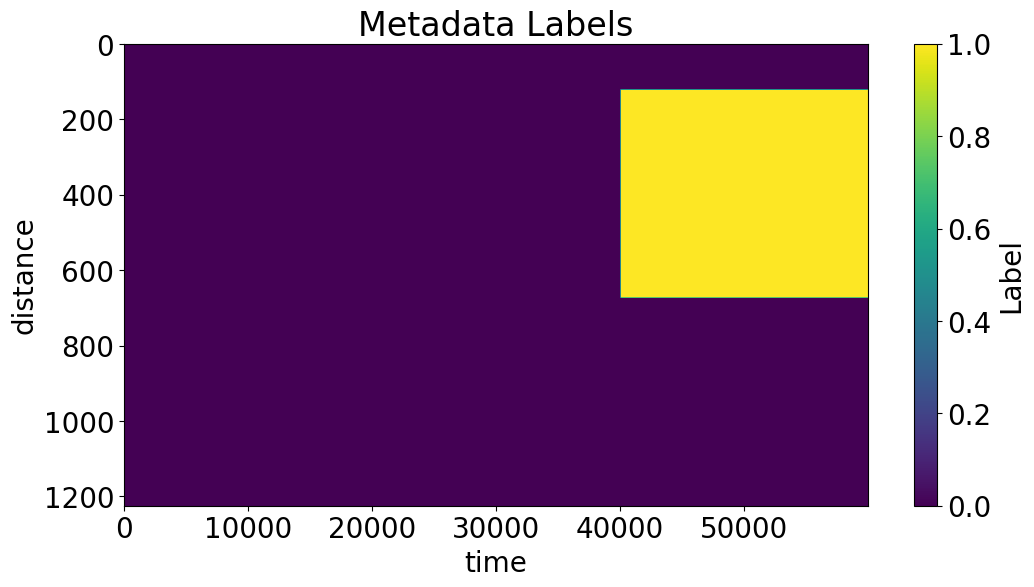

In [ ]:
#plot the metadata to double check that the labels are correct and give values of 1 and 2 different colors
plt.figure(figsize=(12, 6))
plt.imshow(metadata, aspect='auto', cmap='viridis')
plt.colorbar(label='Label')
plt.title('Metadata Labels')
plt.xlabel('time')
plt.ylabel('distance')
plt.show()

In [ ]:
#indexing the dataframe for 1000 time snippets that contain ship noise but keep all distances
df_small = df.iloc[:, 40000:-1]

#pull one column of metadata to use as the target from metadata_small
metadata_small = metadata.iloc[:, 40999:41000]

#rename 204.995 to class
metadata_small.columns = ['class']

#put class and distance on same index row
metadata_small = metadata_small.reset_index()


#add metadata_small to the df_small dataframe
df_small['class'] = metadata_small['class']

#replace NaN values with 0
df_small = df_small.fillna(0)

# Find the closest index values for the given distances within the subset
start_distance_small = df_small.index.searchsorted(50500)
end_distance_small = df_small.index.searchsorted(52750)

# Replace values in class column between distances 50500 and 52750 with 1
df_small.iloc[start_distance_small:end_distance_small, df_small.columns.get_loc('class')] = 1

# Load and prepare the data
X = df_small.drop('class', axis=1).values  # Assuming 'target' is the label column
y = df_small['class'].values


C:\Users\alexa\AppData\Local\Temp\ipykernel_12664\2301715713.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['class'] = metadata_small['class']


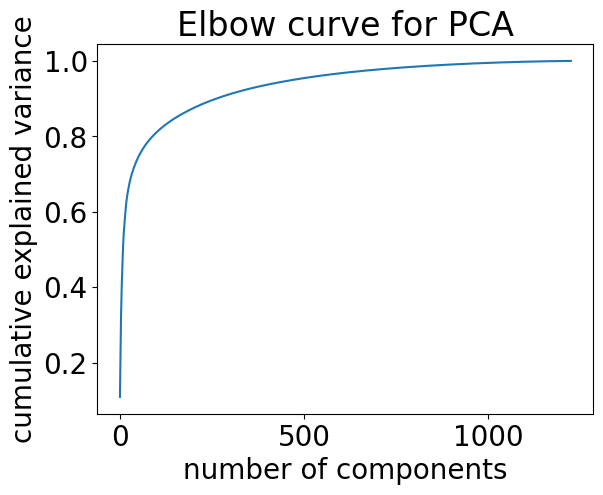

In [ ]:
#plot for # of prinicple components to see how many are needed
from sklearn.decomposition import PCA # type: ignore
pca = PCA()
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Elbow curve for PCA')
plt.show()


In [ ]:
#utilize PCA to reduce the number of dimensions. Utilizing PCA over along the distance rows for every 20 time points
from sklearn.decomposition import PCA # type: ignore
pca = PCA(n_components=1000)
principalComponents = pca.fit_transform(X)

#make for loop to add principle components to a prinicpalDf as columns
principalDf = pd.DataFrame()
for i in range(1000):
    principalDf[i] = principalComponents[:,i]

principalDf


C:\Users\alexa\AppData\Local\Temp\ipykernel_12664\2272648691.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  principalDf[i] = principalComponents[:,i]


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-1.853944e-06,-1.999804e-07,3.991160e-08,-7.508585e-07,1.816959e-06,3.802380e-07,-2.322585e-07,-3.619381e-07,1.161921e-06,-5.289348e-07,...,-9.873920e-09,9.935126e-10,-1.158706e-08,1.232223e-08,9.062388e-09,8.261973e-09,-2.385422e-09,7.012524e-09,-4.633119e-09,-3.851009e-09
1,-1.979168e-06,-2.140987e-07,6.908280e-08,-8.059669e-07,1.921295e-06,3.167503e-07,-2.479981e-07,-4.711329e-07,1.129456e-06,-5.519887e-07,...,4.366692e-08,-5.431433e-09,3.781416e-08,-3.779889e-08,-1.732603e-08,-2.303954e-08,9.805538e-09,-4.006147e-08,-5.562267e-09,-9.879878e-09
2,-2.106494e-06,-2.095326e-07,8.383263e-08,-7.965419e-07,2.003148e-06,3.512436e-07,-2.916426e-07,-4.606898e-07,1.170488e-06,-5.562518e-07,...,-9.182492e-09,-8.029746e-09,-2.547700e-08,7.644950e-09,1.275417e-08,8.573573e-09,-6.484078e-09,1.027631e-08,-2.480366e-09,3.335191e-09
3,-2.063062e-06,-2.636489e-07,7.451598e-08,-7.899742e-07,1.945697e-06,4.326276e-07,-2.955527e-07,-4.451103e-07,1.144541e-06,-5.127759e-07,...,-1.047250e-08,9.231220e-09,9.256599e-09,2.236924e-08,3.570628e-09,1.928288e-09,-8.981465e-09,6.995367e-09,1.529318e-08,-1.357973e-08
4,-1.918829e-06,-2.876176e-07,8.604861e-08,-7.987761e-07,1.842007e-06,4.216637e-07,-3.184487e-07,-3.715136e-07,1.079600e-06,-4.972314e-07,...,2.590614e-08,1.095442e-08,-1.340037e-08,-3.204312e-08,-3.579833e-08,9.889702e-09,2.444944e-08,-3.624573e-09,-6.129293e-08,2.456792e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,-2.333601e-07,-4.601488e-07,-2.086062e-07,-4.678039e-07,1.779930e-07,-2.989243e-07,-1.228520e-07,4.008547e-08,1.570799e-08,1.309590e-07,...,-4.633501e-09,3.493576e-09,1.478938e-09,6.714522e-09,1.587639e-09,7.069679e-09,2.038768e-09,-7.264467e-09,-5.348047e-09,-1.181862e-08
1221,-2.812320e-07,-5.405313e-07,-1.851894e-07,-5.416182e-07,2.033140e-07,-3.642288e-07,-1.429908e-07,7.373980e-08,1.252554e-08,1.237961e-07,...,-4.154105e-09,1.405163e-09,8.575843e-09,8.443736e-09,1.044355e-08,4.358684e-09,-7.114889e-09,-9.581291e-10,-2.841009e-09,6.957947e-09
1222,-3.234127e-07,-6.220390e-07,-1.975985e-07,-5.873267e-07,2.251716e-07,-4.104039e-07,-1.361457e-07,8.845888e-08,1.807966e-09,1.262469e-07,...,8.436498e-09,2.845774e-08,6.003218e-09,1.313237e-08,-1.365135e-08,-5.127692e-09,-1.577558e-09,-4.993667e-09,-1.459358e-08,-7.261987e-09
1223,-3.241486e-07,-6.832597e-07,-2.016312e-07,-6.238203e-07,2.345389e-07,-4.440464e-07,-1.220226e-07,1.113054e-07,1.520720e-08,1.603452e-07,...,-1.341106e-08,-1.939319e-08,-4.210983e-09,-1.554984e-08,1.433064e-08,7.556165e-09,1.685564e-08,-1.483482e-09,3.480360e-09,-3.745637e-09


In [ ]:
#utilize a CNN on the PCA data to see if we can classify any patterns
import torch
import torch.nn as nn
import torch.optim as optim

# choose the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#transform the dataframe into a torch tensor and normalize the data with compose function

data = torch.tensor(principalDf.values, dtype=torch.float32)


L=len(df)
# Training set
Lt = int(0.8*L)




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np

# Convert to PyTorch tensors
X = torch.tensor(data, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Create a dataset and split into training and testing sets
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=5, stride=2, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        # Calculate the output size after all convolutional and pooling layers
        self.conv_output_size = X.shape[1]
        for _ in range(4):  # 4 convolutional layers
            self.conv_output_size = (self.conv_output_size + 2*2 - 5) // 2 + 1  # (input_size + 2*padding - kernel_size) // stride + 1
            self.conv_output_size = (self.conv_output_size - 2) // 2 + 1  # Max pooling layer
        self.fc1 = nn.Linear(16 * max(1, self.conv_output_size), 128)  # Adjust based on input size
        self.fc2 = nn.Linear(128, len(np.unique(y)))  # Number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor while keeping the batch size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, define the loss function and the optimizer
CNN = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.01)

# Define the learning rate
learning_rate = 0.01

# Train the model
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

# Train and evaluate the model
train_model(CNN, train_loader, criterion, optimizer, epochs=25)
evaluate_model(CNN, test_loader)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject